In [1]:
import os
# Changing the working directory
os.chdir('../..')
os.getcwd()

'/home/javiermunoz/Universidad/MasterBDyDS/TFM/TFM_DSBD'

In [2]:
import tensorflow as tf
import keras
from keras import layers
import pathlib

from src.frame_generator import FrameGenerator
from blocks import Conv2Plus1D, ResizeVideo, add_residual_block
from src.config import DATA_PATH, SPLITS
from src.plot_utils import plot_history
import numpy as np

2023-05-26 10:14:20.367802: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 10:14:20.732421: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-26 10:14:21.944889: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib64:/usr/lib/cuda/include:/usr/lib/cuda/lib64:
2023-05-26 10:14:21.944996: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dle

In [3]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

2023-05-26 10:14:23.983860: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-26 10:14:24.167142: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-26 10:14:24.167376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [5]:
subset_size = 20
subset = f"subset_{subset_size}_lsa_64"
model_type = "3DCNN"
model_name = "3dcnn"

In [6]:
subset_paths = {}
for sp in SPLITS:
    subset_paths[sp] = pathlib.Path(os.path.join(DATA_PATH, subset, sp))

In [7]:
n_frames = 10
batch_size = 16

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

2023-05-26 10:14:24.293790: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 10:14:24.296561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-26 10:14:24.296825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-26 10:14:24.297041: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [9]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(subset_size)(x)

model = keras.Model(input, x)

In [10]:
frames, label = next(iter(train_ds))
model.build(frames)

2023-05-26 10:14:38.446920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 1000
2023-05-26 10:14:50.680634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 6 of 1000
2023-05-26 10:14:58.550574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 8 of 1000
2023-05-26 10:15:10.844208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 11 of 1000
2023-05-26 10:15:19.380188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 13 of 1000
2023-05-26 10:15:27.748919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 15 of 1000
2023-05-26 10:15:40.438855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (th

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 224, 22  0           []                               
                                4, 3)]                                                            
                                                                                                  
 conv2_plus1d (Conv2Plus1D)     (None, 10, 224, 224  3152        ['input_1[0][0]']                
                                , 16)                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 10, 224, 224  64         ['conv2_plus1d[0][0]']           
 alization)                     , 16)                                                         

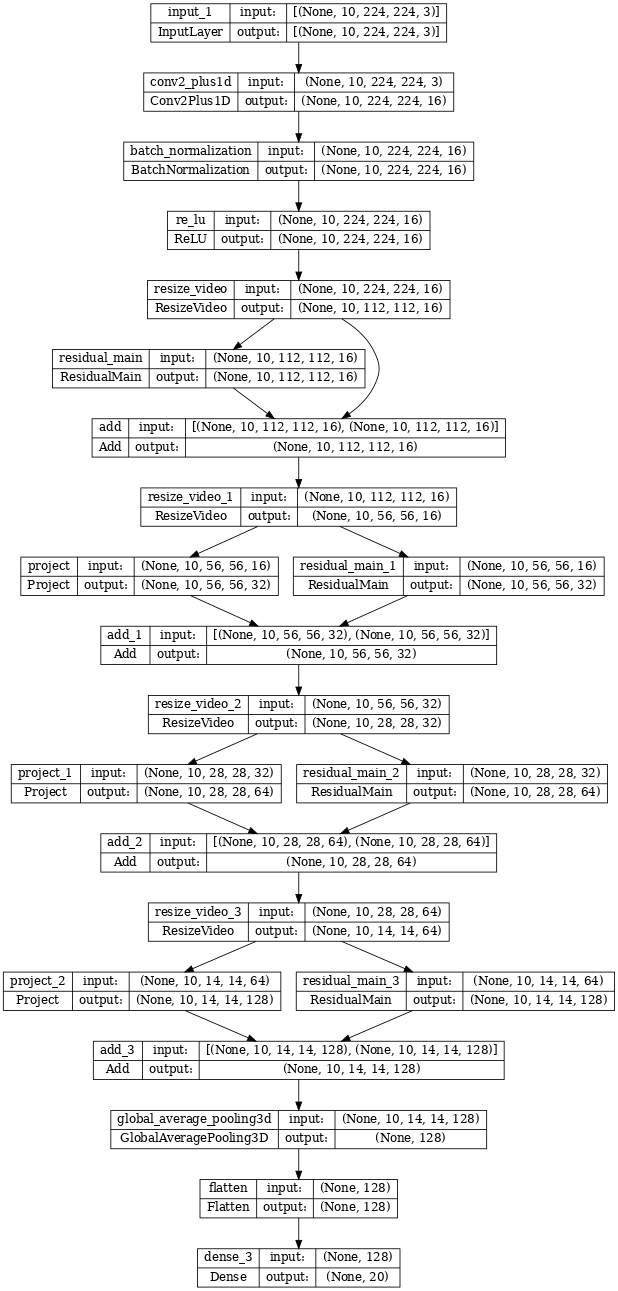

In [12]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [13]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [15]:
# CReate a customized callback so when val_acc > 94% it stops training
from keras.callbacks import EarlyStopping, ModelCheckpoint

class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

bst_model_path = "src/"+model_type+"/bestmodels/best_"+model_name+"_{epoch:02d}_{val_accuracy:.2f}_"+str(subset_size)+"_model.h5"

callbacks = [
    EarlyStopping(monitor="loss", patience=15),
    EarlyStopping(monitor="accuracy", patience=15),
    ModelCheckpoint(filepath=bst_model_path, save_best_only=True, save_weights_only=True, monitor="val_accuracy", mode='max'),
    MyThresholdCallback(threshold=0.94)
    
]


In [16]:
history = model.fit(train_ds,
                    epochs=120, 
                    validation_data=val_ds,
                    callbacks=callbacks,
                    batch_size=batch_size)

Epoch 1/120


2023-05-26 10:18:20.839832: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2023-05-26 10:18:21.809501: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-26 10:18:22.268175: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


      6/Unknown - 10s 714ms/step - loss: 3.5427 - accuracy: 0.0417WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2989s vs `on_train_batch_end` time: 0.3483s). Check your callbacks.
     51/Unknown - 42s 723ms/step - loss: 3.1230 - accuracy: 0.0602

2023-05-26 10:19:13.870558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 1000
2023-05-26 10:19:22.104848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 1000
2023-05-26 10:19:29.383928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


51/51 [==============================] - 74s 1s/step - loss: 3.1230 - accuracy: 0.0602 - val_loss: 3.0705 - val_accuracy: 0.0093
Epoch 2/120
51/51 [==============================] - 38s 753ms/step - loss: 2.9140 - accuracy: 0.0860 - val_loss: 3.1921 - val_accuracy: 0.0093
Epoch 3/120
51/51 [==============================] - 38s 752ms/step - loss: 2.8306 - accuracy: 0.0971 - val_loss: 2.8426 - val_accuracy: 0.0654
Epoch 4/120
51/51 [==============================] - 38s 753ms/step - loss: 2.8037 - accuracy: 0.0946 - val_loss: 2.7525 - val_accuracy: 0.0935
Epoch 5/120
51/51 [==============================] - 38s 755ms/step - loss: 2.7693 - accuracy: 0.0958 - val_loss: 2.8340 - val_accuracy: 0.0654
Epoch 6/120
51/51 [==============================] - 39s 757ms/step - loss: 2.6612 - accuracy: 0.1290 - val_loss: 3.0696 - val_accuracy: 0.0748
Epoch 7/120
51/51 [==============================] - 39s 758ms/step - loss: 2.4487 - accuracy: 0.1757 - val_loss: 3.2494 - val_accuracy: 0.1028
Epoch 8

In [17]:
best_model_epoch = np.argmax(history.history['val_accuracy'])
best_acc, best_loss, best_val_acc, best_val_loss = history.history['accuracy'][best_model_epoch], history.history['loss'][best_model_epoch], history.history['val_accuracy'][best_model_epoch], history.history['val_loss'][best_model_epoch]

In [19]:
#best_model = tf.keras.models.load_model(f"src/{model_type}/bestmodels/best_{model_name}_{(best_model_epoch+1):02d}_{best_val_acc:.2f}_model.h5")

model.load_weights(f"src/{model_type}/bestmodels/best_{model_name}_{(best_model_epoch+1):02d}_{best_val_acc:.2f}_{subset_size}_model.h5")

In [20]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
test_results = model.evaluate(test_ds, batch_size=batch_size)
print("test loss, test acc:", test_results)

Evaluate on test data
5/5 [==============================] - 22s 4s/step - loss: 0.6013 - accuracy: 0.8608
test loss, test acc: [0.6012700796127319, 0.8607594966888428]


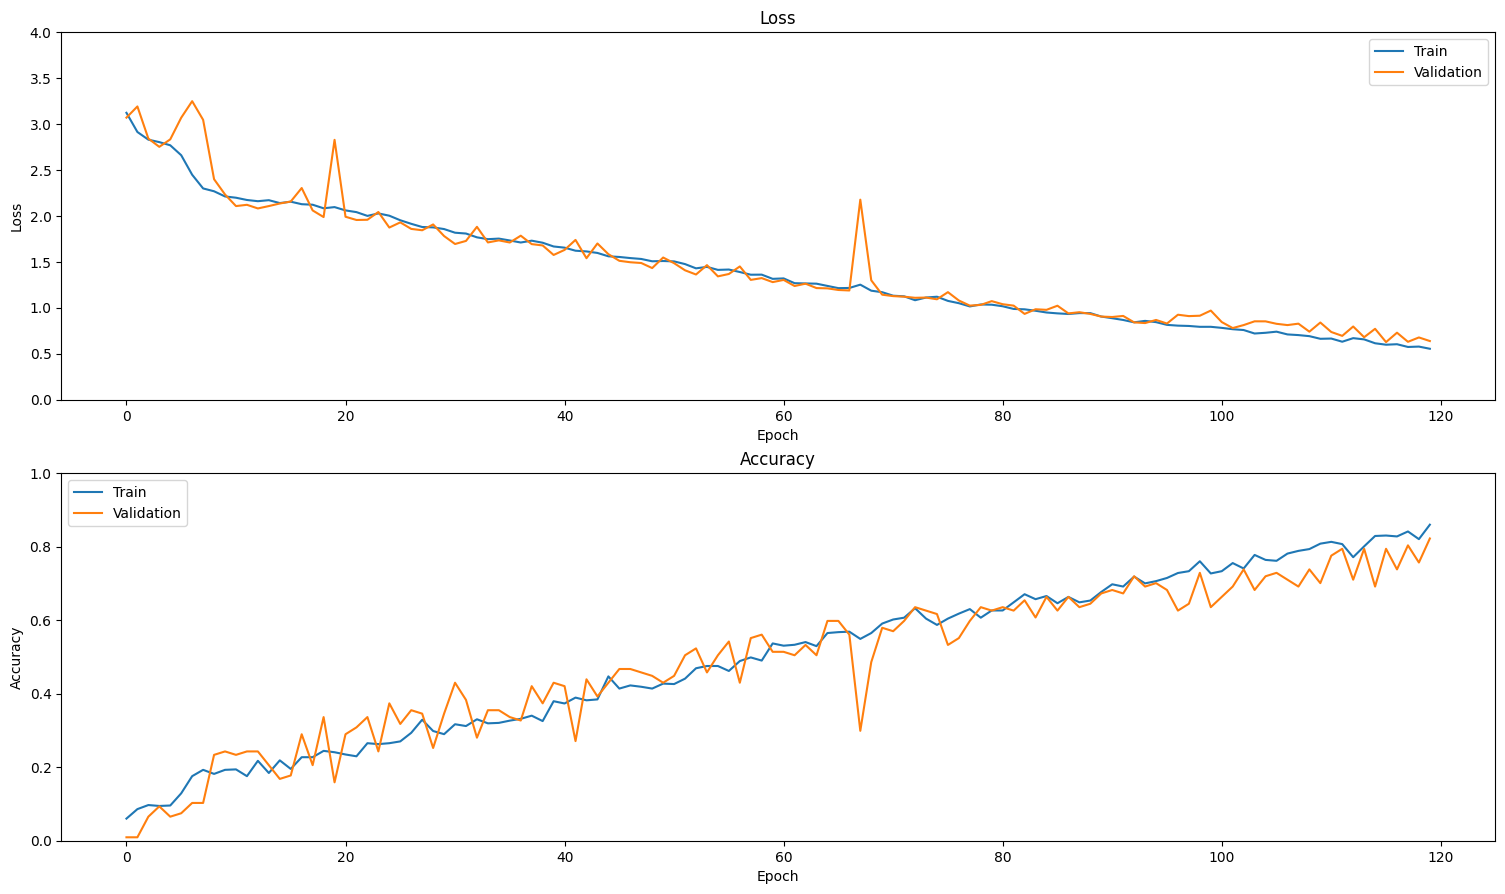

In [21]:
plot_history(history)

In [22]:
from src.leaderboard import Leaderboard

lb = Leaderboard()
lb.update_leaderboard(history=history,
                      test_results=test_results,
                      model_name=model_name,
                      model_type=model_type,
                      subset_size=subset_size)

lb.lb

,model_type,model_name,train_acc,val_acc,test_acc,train_loss,val_loss,test_loss,epoch,path_to_model,subset_size
0,convlstm,simple,0.96,0.93,0.93,0.15,0.20,0.19,39.0,src/convlstm/bestmodels/best_simple_39_0.93_10...,10.0
1,convlstm,stateless,0.93,0.95,0.91,0.22,0.19,0.19,22.0,src/convlstm/bestmodels/best_stateless_22_0.95...,10.0
2,3DCNN,3dcnn,0.92,0.90,0.87,0.35,0.39,0.42,63.0,src/3DCNN/bestmodels/best_3dcnn_63_0.90_10_mod...,10.0
3,mediapipe,mp,0.90,0.90,0.87,0.27,0.35,0.54,178.0,src/mediapipe/bestmodels/best_mp_178_0.90_mode...,20.0
4,mediapipe,mp,0.89,0.85,0.85,0.38,0.62,0.43,159.0,src/mediapipe/bestmodels/best_mp_159_0.85_mode...,40.0
5,mediapipe,mp,0.93,0.86,0.86,0.24,0.63,0.55,167.0,src/mediapipe/bestmodels/best_mp_167_0.86_mode...,30.0
6,mediapipe,mp,0.92,0.86,0.05,0.25,0.50,13.10,194.0,src/mediapipe/bestmodels/best_mp_194_0.86_mode...,50.0
7,convlstm,simple,0.90,0.85,0.80,0.32,0.52,0.82,127.0,src/convlstm/bestmodels/best_simple_127_0.85_m...,30.0
8,3DCNN,3dcnn,0.86,0.82,0.86,0.55,0.64,0.60,120.0,src/3DCNN/bestmodels/best_3dcnn_120_0.82_model.h5,20.0
